#### [자연어처리] 텍스트 분류 모델 구현 단어 사전 미사용

- 데이터 셋 : 200개 한국어 뉴스 기사
- 라 벨 : 정치(0), 경제(1), 사회(2), 생활/문화(3), 세계(4), 기술/IT(5), 연예(6), 스포츠(7)

- 입력 받은 TEXT에 대한 기사 종류 분류 결과 출력

In [6]:
import os
import re
from konlpy.tag import Okt, Komoran
import pandas as pd

# 1. 뉴스 카테고리 폴더 경로 설정
dataset_dir = r"C:\Users\kimjaesung\9.자연어처리\nltk_project\nltkText_Dataset"
categories = ['정치', '경제', '사회', '생활/문화', '세계', '기술/IT', '연예', '스포츠']

# 2. 뉴스를 저장할 리스트
news_data = []

# 3. 각 폴더에서 텍스트 파일 읽기 및 저장
for category_id, category_name in enumerate(categories):
    category_path = os.path.join(dataset_dir, str(category_id))
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            news_data.append((content, category_name))

print(f"뉴스 데이터 수: {len(news_data)}")  # 데이터 개수 확인

# 4. 형태소 분석기 설정 및 불용어 리스트 정의 (Komoran 사용)
komoran = Komoran()
stopwords = [
    '이', '그', '저', '것', '들', '에서', '이다', '있다', '합니다', '했는데', '그리고', 
    '과', '도', '는', '다시', '또는', '그러나', '이후', '지금', '경우', '등', 
    '동안', '뿐만', '중', '하지만', '그러나', '이같이'
]


# 5. 전처리 함수 정의 (Komoran 형태소 분석기 사용 + 공백 처리)
def preprocess(text):
    # 특수문자 제거 (한글과 숫자 및 일부 기호만 남김)
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9%$ ]", "", text)
    
    # 연속된 공백을 하나의 공백으로 변환하고, 양 끝의 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 형태소 분석 및 어간 추출 (Komoran 사용)
    tokens = komoran.morphs(text)
    
    # 불용어 제거 및 빈 토큰 제거
    tokens = [word for word in tokens if word not in stopwords and word.strip() != ""]
    
    return tokens if tokens else ['<EMPTY>']  # 빈 리스트 대체

# 6. 뉴스 데이터를 전처리하여 토큰화 및 카테고리 저장
processed_news_data = [(preprocess(content), category) for content, category in news_data]

# 7. 토큰화된 데이터를 그대로 CSV로 저장
df_processed_news = pd.DataFrame(processed_news_data, columns=['tokens', 'category'])

# 각 행의 토큰 리스트를 공백으로 연결하여 저장
df_processed_news['tokens'] = df_processed_news['tokens'].apply(lambda x: ' '.join(x))

# 8. 전처리된 뉴스 데이터를 CSV로 저장
df_processed_news.to_csv("processed_news_data_komoran.csv", index=False, encoding='utf-8-sig')

print("전처리된 데이터가 CSV 파일로 저장되었습니다.")



뉴스 데이터 수: 1600
전처리된 데이터가 CSV 파일로 저장되었습니다.


In [7]:
df_processed_news.isna().sum()

tokens      0
category    0
dtype: int64

In [15]:
import os
import re
from konlpy.tag import Okt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from gensim.models import Word2Vec

# 1. 데이터 로드 및 전처리
df = pd.read_csv("processed_news_data_komoran.csv")

df['tokens'] = df['tokens'].apply(lambda x: x.split())
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

# 2. Word2Vec 모델 학습
sentences = df['tokens'].tolist()
embedding_dim = 300  # 벡터 크기와 임베딩 차원을 동일하게 설정
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# 3. Word2Vec 모델에서 임베딩 매트릭스 추출
vocab_size = len(word2vec_model.wv.key_to_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2vec_model.wv.key_to_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]


# 4. 단어를 인덱스로 변환
word_to_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key, 1)}
word_to_index['<PAD>'] = 0

max_len = 100
def pad_sequences(tokens, max_len):
    return [token[:max_len] + ['<PAD>'] * (max_len - len(token)) for token in tokens]

padded_tokens = pad_sequences(df['tokens'].values, max_len)
X_data = [[word_to_index.get(word, 0) for word in tokens] for tokens in padded_tokens]
X_data = np.array(X_data)

# 5. 라벨 데이터 분리
y_data = df['category'].values

# 6. 학습/검증/테스트 데이터셋 분리
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 7. 텐서 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 16  # 배치 크기를 줄임
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 8. 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# 9. LSTM 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, n_layers, n_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = True  # 임베딩 레이어를 학습 가능하도록 설정
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        output = self.fc(self.dropout(lstm_out[:, -1, :]))
        return output

# 10. 모델 초기화
n_classes = len(le.classes_)
hidden_dim = 256  # 은닉층 크기 증가
n_layers = 3  # LSTM 레이어 수 증가

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, 
                       n_layers=n_layers, n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # 클래스 가중치 반영
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # 학습률 및 L2 정규화 추가


# 모델 학습 및 성능 평가 실행


# 11. 성능 평가 함수 정의
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

# 12. 모델 학습 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40, save_path='best_word2vec_lstm_model.pth', patience=5):
    best_val_f1 = 0
    patience_counter = 0  # 성능이 개선되지 않은 에포크 수를 기록
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        train_accuracy = correct_predictions / total_predictions
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        
        # 검증 데이터 평가
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)
                
                all_val_preds.extend(val_outputs.cpu().numpy())
                all_val_labels.extend(val_labels.cpu().numpy())
        
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        
        # 최적의 모델 저장
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0  # 성능이 개선되면 patience 카운터를 초기화
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with F1 Score: {best_val_f1:.4f}')
        else:
            patience_counter += 1  # 성능이 개선되지 않았을 때 카운터 증가
            print(f'Early stopping patience counter: {patience_counter}/{patience}')
        
        # 조기 종료 조건
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()


# 13. 모델 학습
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=80, patience=5)







Epoch [1/40], Loss: 145.6260, Train Accuracy: 0.1339


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 31.2037, Accuracy: 0.1417, Precision: 0.0326, Recall: 0.1417, F1 Score: 0.0442
Best model saved with F1 Score: 0.0442
Epoch [2/40], Loss: 145.5319, Train Accuracy: 0.1473


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 31.1668, Accuracy: 0.1250, Precision: 0.1275, Recall: 0.1250, F1 Score: 0.0805
Best model saved with F1 Score: 0.0805
Epoch [3/40], Loss: 145.3752, Train Accuracy: 0.1536


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 31.1266, Accuracy: 0.1875, Precision: 0.1018, Recall: 0.1875, F1 Score: 0.1237
Best model saved with F1 Score: 0.1237
Epoch [4/40], Loss: 145.1313, Train Accuracy: 0.1571


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 31.0839, Accuracy: 0.1458, Precision: 0.1416, Recall: 0.1458, F1 Score: 0.1322
Best model saved with F1 Score: 0.1322
Epoch [5/40], Loss: 144.2976, Train Accuracy: 0.1732


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 30.9049, Accuracy: 0.1500, Precision: 0.1072, Recall: 0.1500, F1 Score: 0.1124
Early stopping patience counter: 1/5
Epoch [6/40], Loss: 143.7716, Train Accuracy: 0.1777
Validation Loss: 30.5792, Accuracy: 0.1542, Precision: 0.1789, Recall: 0.1542, F1 Score: 0.1141
Early stopping patience counter: 2/5
Epoch [7/40], Loss: 140.9528, Train Accuracy: 0.2107


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 29.9284, Accuracy: 0.2250, Precision: 0.1258, Recall: 0.2250, F1 Score: 0.1602
Best model saved with F1 Score: 0.1602
Epoch [8/40], Loss: 136.2306, Train Accuracy: 0.2375


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 29.5509, Accuracy: 0.2375, Precision: 0.1491, Recall: 0.2375, F1 Score: 0.1637
Best model saved with F1 Score: 0.1637
Epoch [9/40], Loss: 134.7565, Train Accuracy: 0.2339
Validation Loss: 29.5271, Accuracy: 0.2542, Precision: 0.1752, Recall: 0.2542, F1 Score: 0.1879
Best model saved with F1 Score: 0.1879
Epoch [10/40], Loss: 128.3919, Train Accuracy: 0.2759
Validation Loss: 28.9445, Accuracy: 0.2750, Precision: 0.2153, Recall: 0.2750, F1 Score: 0.2071
Best model saved with F1 Score: 0.2071
Epoch [11/40], Loss: 128.2955, Train Accuracy: 0.2884
Validation Loss: 29.4393, Accuracy: 0.2583, Precision: 0.2860, Recall: 0.2583, F1 Score: 0.2217
Best model saved with F1 Score: 0.2217
Epoch [12/40], Loss: 119.7458, Train Accuracy: 0.3384
Validation Loss: 28.0481, Accuracy: 0.2958, Precision: 0.2824, Recall: 0.2958, F1 Score: 0.2733
Best model saved with F1 Score: 0.2733
Epoch [13/40], Loss: 115.8189, Train Accuracy: 0.3429


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 27.2634, Accuracy: 0.3083, Precision: 0.3108, Recall: 0.3083, F1 Score: 0.2714
Early stopping patience counter: 1/5
Epoch [14/40], Loss: 108.4255, Train Accuracy: 0.4107
Validation Loss: 26.8919, Accuracy: 0.3292, Precision: 0.3013, Recall: 0.3292, F1 Score: 0.3066
Best model saved with F1 Score: 0.3066
Epoch [15/40], Loss: 100.8609, Train Accuracy: 0.4384
Validation Loss: 26.1291, Accuracy: 0.3708, Precision: 0.3497, Recall: 0.3708, F1 Score: 0.3552
Best model saved with F1 Score: 0.3552
Epoch [16/40], Loss: 91.4282, Train Accuracy: 0.5000
Validation Loss: 25.7868, Accuracy: 0.3792, Precision: 0.4211, Recall: 0.3792, F1 Score: 0.3754
Best model saved with F1 Score: 0.3754
Epoch [17/40], Loss: 84.2225, Train Accuracy: 0.5509
Validation Loss: 26.0667, Accuracy: 0.3542, Precision: 0.3983, Recall: 0.3542, F1 Score: 0.3476
Early stopping patience counter: 1/5
Epoch [18/40], Loss: 76.5921, Train Accuracy: 0.5848
Validation Loss: 25.0278, Accuracy: 0.3958, Precision: 0.4171,

category
정치       200
경제       200
사회       200
생활/문화    200
세계       200
기술/IT    200
연예       200
스포츠      200
Name: count, dtype: int64


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49324 (\N{HAN

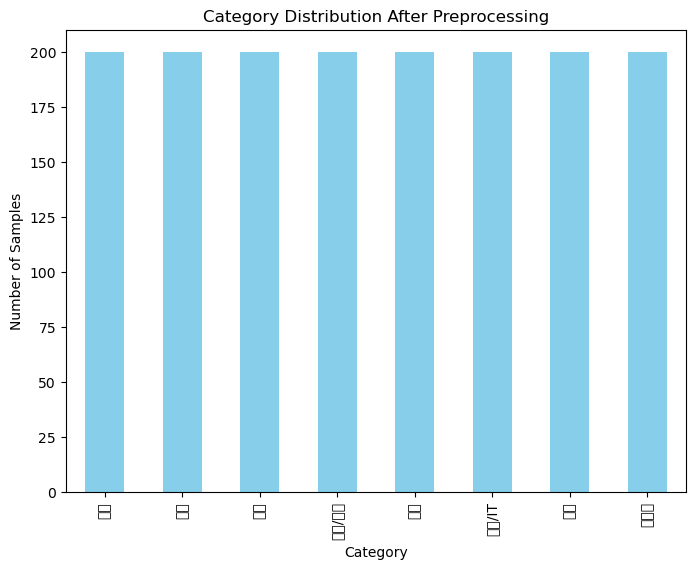

c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49324 (\N{HAN

category
정치       12.5
경제       12.5
사회       12.5
생활/문화    12.5
세계       12.5
기술/IT    12.5
연예       12.5
스포츠      12.5
Name: proportion, dtype: float64


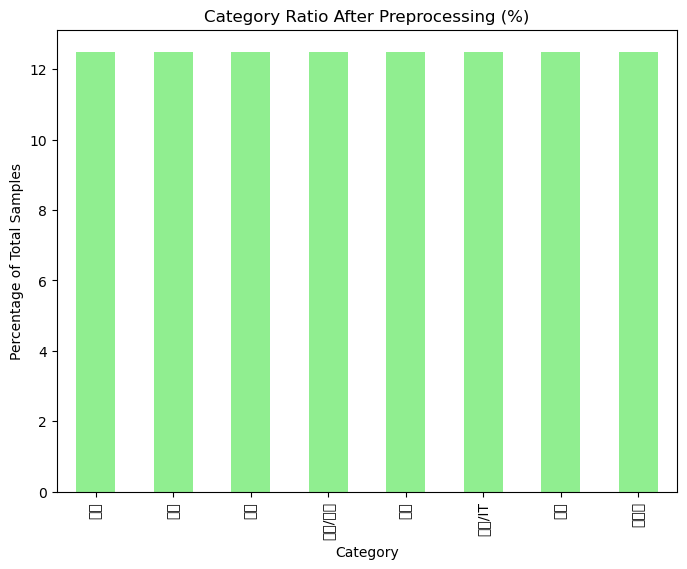

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 성능이 좋지 않아서 데이터 불균형이 원인인가 확인

# 전처리된 뉴스 데이터를 데이터프레임으로 변환
df_processed_news = pd.DataFrame(processed_news_data, columns=['tokens', 'category'])

# 카테고리별 샘플 수 확인
category_counts = df_processed_news['category'].value_counts()

# 각 카테고리별 데이터 개수 출력
print(category_counts)

# 카테고리별 샘플 수 시각화
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Distribution After Preprocessing')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

# 카테고리별 비율 계산
category_ratio = df_processed_news['category'].value_counts(normalize=True) * 100

# 카테고리별 비율 출력
print(category_ratio)

# 카테고리별 비율 시각화
plt.figure(figsize=(8, 6))
category_ratio.plot(kind='bar', color='lightgreen')
plt.title('Category Ratio After Preprocessing (%)')
plt.xlabel('Category')
plt.ylabel('Percentage of Total Samples')
plt.show()

# 데이터 불균형 문제아님


In [25]:
# 임베딩 레이어 조정

# BERT를 사용한 모델 

# transformers 모듈 사용한 코드

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd

# 1. 데이터 로드 및 전처리
df = pd.read_csv("processed_news_data_komoran.csv")

df['tokens'] = df['tokens'].apply(lambda x: x.split())
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

# 2. BERT 모델 및 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

# 3. 텍스트를 BERT 입력 형식으로 변환
def encode_texts(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

max_len = 100  # 문장 길이

# 토큰화된 데이터를 공백으로 결합한 후 BERT 형식으로 변환
texts = [' '.join(tokens) for tokens in df['tokens']]
input_ids, attention_masks = encode_texts(texts, tokenizer, max_len)

# 4. 라벨 데이터 분리
y_data = df['category'].values
y_data_tensor = torch.tensor(y_data, dtype=torch.long)  # Ensure labels are in Long format

# 5. 학습/검증/테스트 데이터셋 분리
X_train, X_temp, y_train, y_temp = train_test_split(input_ids, y_data_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

attention_train, attention_temp, _, _ = train_test_split(attention_masks, y_data_tensor, test_size=0.3, random_state=42)
attention_val, attention_test, _, _ = train_test_split(attention_temp, y_temp, test_size=0.5, random_state=42)

# 6. collate_fn 함수 정의 : 배치 내에서 다르게 패딩된 시퀀스가 있을 경우를 대비한 추가 작업
def collate_fn(batch):
    input_ids = [item[0] for item in batch]
    attention_masks = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return input_ids_padded, attention_masks_padded, labels_tensor

# 7. 텐서 변환 및 DataLoader 정의
train_dataset = TensorDataset(X_train, attention_train, y_train)
val_dataset = TensorDataset(X_val, attention_val, y_val)
test_dataset = TensorDataset(X_test, attention_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# 8. BERT 기반 LSTM 분류 모델 정의
class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, n_classes, dropout=0.3):
        super(BERTLSTMClassifier, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers=2, 
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(bert_output.last_hidden_state)
        output = self.fc(self.dropout(lstm_out[:, -1, :]))  # 마지막 LSTM 타임스텝만 사용
        return output

# 9. 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_dim = 256  # 은닉층 크기
n_classes = len(le.classes_)
model = BERTLSTMClassifier(bert_model, hidden_dim, n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 10. 성능 평가 함수 정의
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

# 11. 모델 학습 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=80, save_path='best_bert_lstm_model.pth', patience=12):
    best_val_f1 = 0
    patience_counter = 0  # 성능이 개선되지 않은 에포크 수를 기록
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for input_ids, attention_masks, labels in train_loader:
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)
            
            outputs = model(input_ids, attention_masks)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        train_accuracy = correct_predictions / total_predictions
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        
        # 검증 데이터 평가
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for val_input_ids, val_attention_masks, val_labels in val_loader:
                val_input_ids, val_attention_masks, val_labels = val_input_ids.to(device), val_attention_masks.to(device), val_labels.to(device)
                val_outputs = model(val_input_ids, val_attention_masks)
                val_loss += criterion(val_outputs, val_labels).item()
                
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)
                
                all_val_preds.extend(val_outputs.cpu().numpy())
                all_val_labels.extend(val_labels.cpu().numpy())
        
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        
        # 최적의 모델 저장
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0  # 성능이 개선되면 patience 카운터를 초기화
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with F1 Score: {best_val_f1:.4f}')
        else:
            patience_counter += 1  # 성능이 개선되지 않았을 때 카운터 증가
            print(f'Early stopping patience counter: {patience_counter}/{patience}')
        
        # 조기 종료 조건
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()

# 12. 모델 학습
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=80, patience=12)





Epoch [1/80], Loss: 144.4298, Train Accuracy: 0.1821


c:\Users\KDP-26\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 30.3141, Accuracy: 0.3042, Precision: 0.3434, Recall: 0.3042, F1 Score: 0.2506
Best model saved with F1 Score: 0.2506
Epoch [2/80], Loss: 126.5257, Train Accuracy: 0.4170
Validation Loss: 20.4332, Accuracy: 0.6125, Precision: 0.6446, Recall: 0.6125, F1 Score: 0.5954
Best model saved with F1 Score: 0.5954
Epoch [3/80], Loss: 90.5950, Train Accuracy: 0.5705
Validation Loss: 15.2728, Accuracy: 0.6667, Precision: 0.6840, Recall: 0.6667, F1 Score: 0.6650
Best model saved with F1 Score: 0.6650
Epoch [4/80], Loss: 78.0643, Train Accuracy: 0.6098
Validation Loss: 13.7984, Accuracy: 0.7125, Precision: 0.7205, Recall: 0.7125, F1 Score: 0.7077
Best model saved with F1 Score: 0.7077
Epoch [5/80], Loss: 69.5247, Train Accuracy: 0.6768
Validation Loss: 13.7982, Accuracy: 0.6625, Precision: 0.6646, Recall: 0.6625, F1 Score: 0.6337
Early stopping patience counter: 1/12
Epoch [6/80], Loss: 61.7988, Train Accuracy: 0.7205
Validation Loss: 11.1161, Accuracy: 0.7542, Precision: 0.7600, Re